# AppStat 2023 Project

## Group Members
- Andras
- Ellen
- Oscar
- Pernille
- Rasmine 

## Error propagation
Error propagation the local acceleration due to gravity _g_ using a pendulum and a slope experiment.

In [100]:
# Import SymPy: 
from sympy import * 
    
# Define variables:
L,T,theta,R,d, gp, gs,a = symbols("L, T, theta, R, d, g_pendulum, g_slope,a")
dL,dT,dth,dR,dd,dgp,dgs,da = symbols("sigma_L, sigma_T, sigma_theta, sigma_r, sigma_d, sigma_gP,sigma_gS,sigma_a")

# Pendulum:
# Define relation, and print:
gp = L * (2 * pi / T)**2 
lprint(latex(Eq(symbols('g_pendulum'),gp)))

# Calculate uncertainty and print:
dgp = sqrt((gp.diff(L) * dL)**2 + (gp.diff(T) * dT)**2)
lprint(latex(Eq(symbols('sigma_gP'), dgp)))

# Turn expression into numerical functions 
fP = lambdify((L,T),gp)
fdP = lambdify((L,dL,T,dT),dgp)

# Define values and their errors
# vL, vdL = mu1,sig1
# vT, vdT = mu2,sig2

vL, vdL = 1.5,0.2
vT, vdT = 3,0.5


# Numerically evaluate expressions and print 
vP = fP(vL,vT)
vdP = fdP(vL,vdL,vT,vdT)
lprint(fr'g = ({vP:.3f} \pm {vdP:.3f})\,\mathrm{{m/s^2}}')

# Pendulum:
# Define relation, and print:
gs = a/sin(theta) * (1+2/5 * R**2 / (R**2-(d/2)**2)) 
lprint(latex(Eq(symbols('g_slope'),gs)))

# Calculate uncertainty and print:
dgs = sqrt((gs.diff(a) * da)**2 + (gs.diff(theta) * dth)**2+ (gs.diff(R) * dR)**2+ (gs.diff(d) * dd)**2)
lprint(latex(Eq(symbols('sigma_gS'), dgs)))

# Turn expression into numerical functions 
fP = lambdify((a,theta,R,d),gs)
fdP = lambdify((a,da,theta,dth,R,dR,d,dd),dgs)

# Define values and their errors
# vL, vdL = mu1,sig1
# vT, vdT = mu2,sig2
va,vtheta,vR,vd = 6.2, 30, 5, 5.0

vda,vdtheta,vdR,vdd = 0.2, 2, 0.2, 0.1

# Numerically evaluate expressions and print 
vP = fP(va,vtheta,vR,vd)
vdP = fdP(va,vda,vtheta,vdtheta,vR,vdR,vd,vdd)
lprint(fr'g = ({vP:.3f} \pm {vdP:.3f})\,\mathrm{{m/s^2}}')



# NOTE: Do the above analytical calculation before you continue below! Possibly use SymPy for the differentiations.

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Pendulum
- Pendulum length: Measured both with measuring tape and laser.
- Pendulum period: Measured over several (e.g. 25+) swings.
- Pendulum timing precisions: Accuracy of timing of each team member 

In [101]:
import numpy as np     
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab   
from scipy import stats                             # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Modules to see files and folders in directories


sys.path.append('External_Functions')
from ExternalFunctions import Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax 



r = np.random                         # Random generator
r.seed(42)  


In [102]:
pend_1  = np.loadtxt('Data/data_Alice_pendulum14m_25measurements.dat', delimiter='\t')
pend_2  = np.loadtxt('Data/data_Bob_pendulum14m_25measurements.dat', delimiter='\t')
slop_1  = np.loadtxt('Data/data_NormDir_MedBall1.txt', delimiter='\t')
slop_2  = np.loadtxt('Data/data_RevDir_MedBall1.txt', delimiter='\t')

periods = np.full_like(np.ones((5,25)),7.51)

for i in range(2,5):
    periods[i] = periods[i]*(np.arange(25)+1)+ r.normal(0, 0.033, 25)

periods[0] = pend_1[:,1]
periods[1] = pend_2[:,1]



In [103]:
def linear_model(x, a, b):
    return a * x + b

# Gaussian function for fitting
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean)**2) / (2 * stddev**2))

def calculate_rms_residuals(x_data, y_data, fit_params):
    residuals = y_data - linear_model(x_data, *fit_params)
    return np.sqrt(np.mean(residuals**2))

In [128]:
N_measurements = 25
N_exp = 2
x_data = np.arange(N_measurements)+1
N_bins = 5

Pendulum_Chi2 = np.zeros(N_exp)
Pendulum_Prob = np.zeros(N_exp)

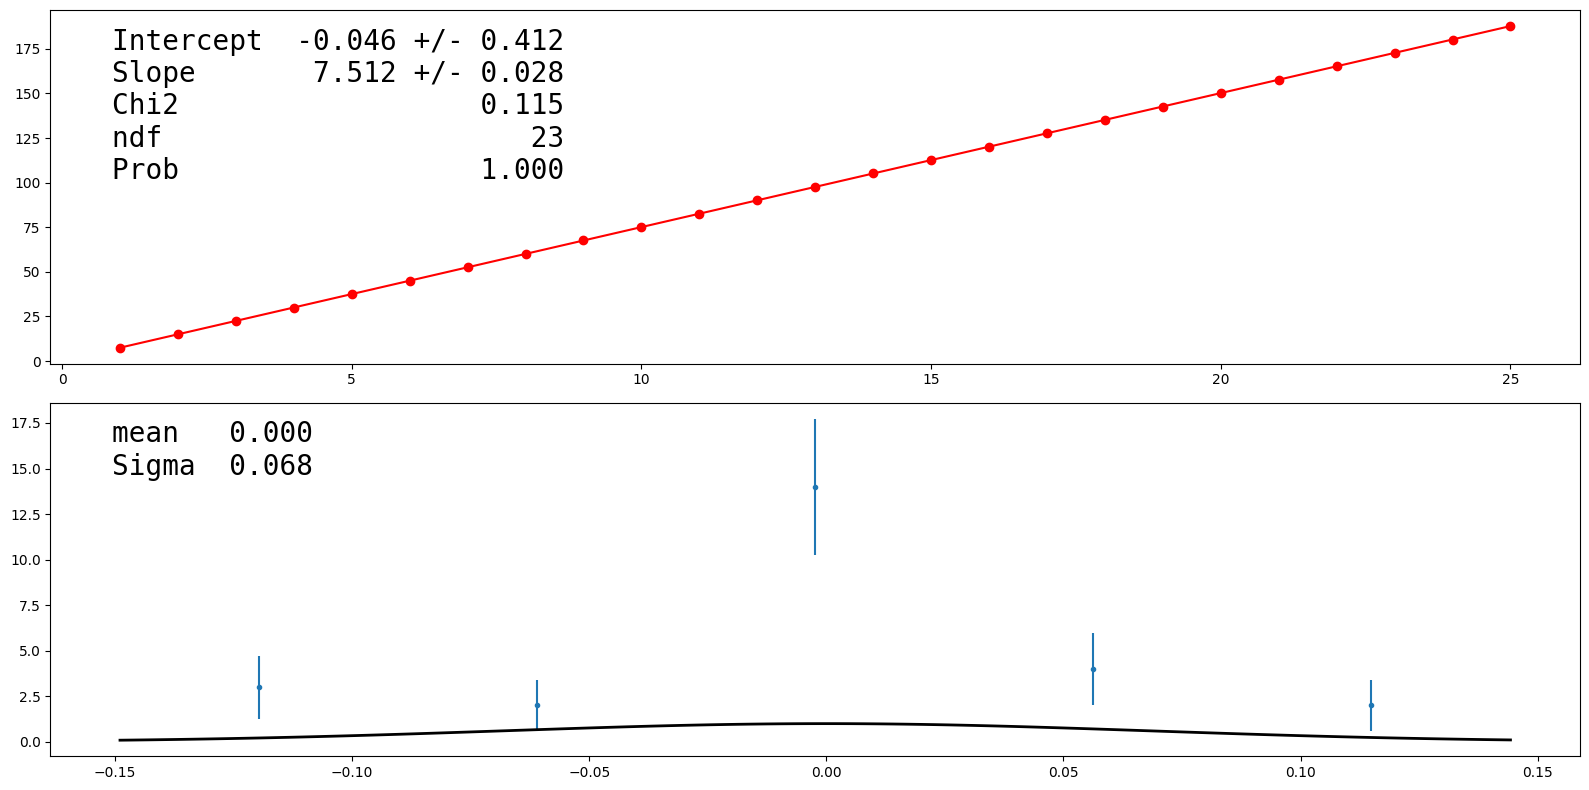

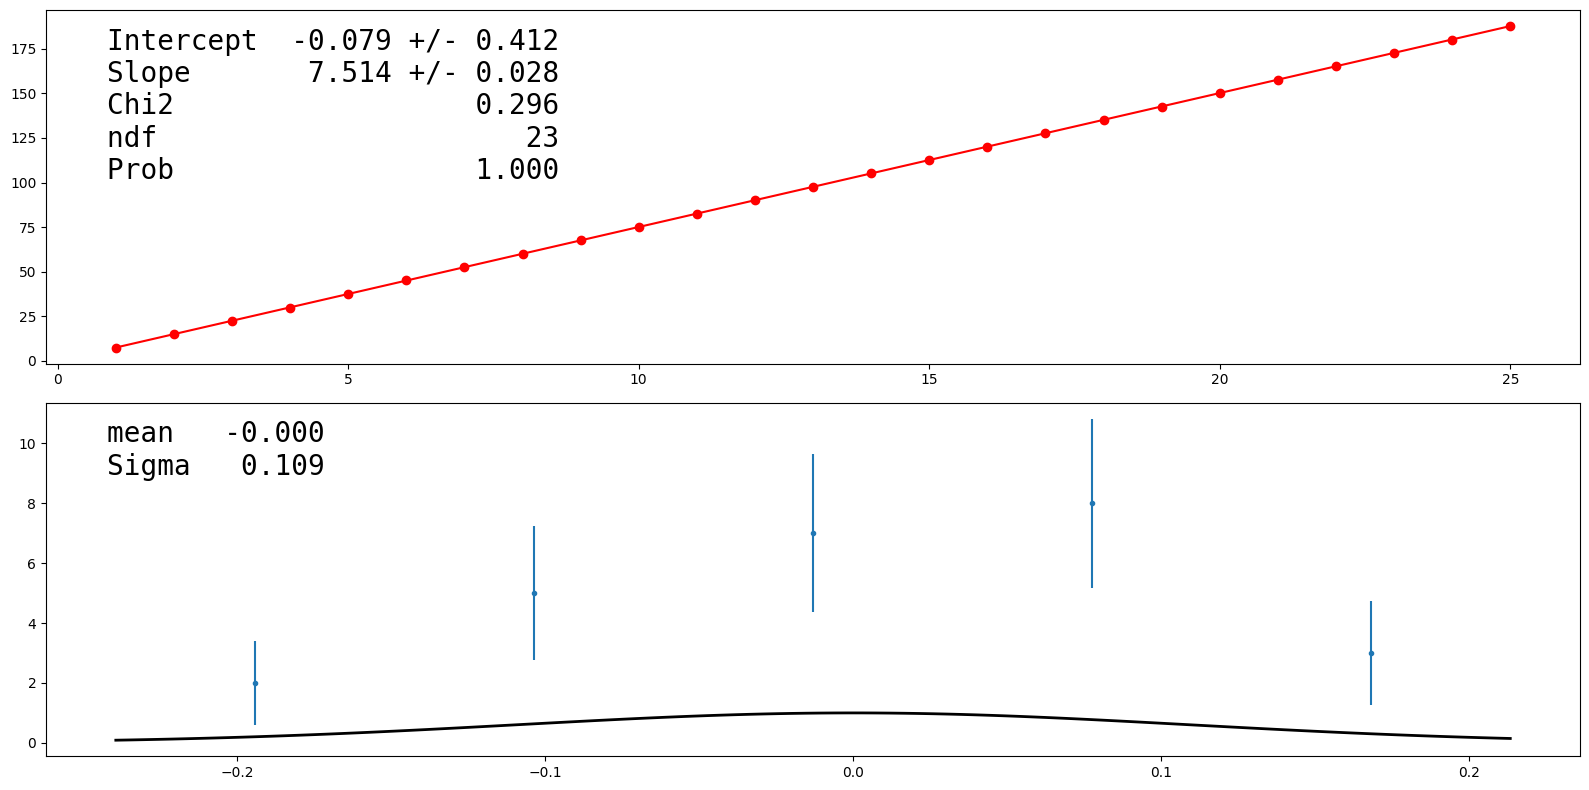

In [129]:
for iexp in range(N_exp):


    chi2_object = Chi2Regression(linear_model, x_data, periods[iexp])
    m = Minuit(chi2_object,a=7.5,b=0)
    m.migrad()

    Chi2Lin = m.fval # the chi2 value
    NvarLin = 2                      # Number of variables (alpha0 and alpha1)
    NdofLin = N_measurements - NvarLin   # Number of degrees of freedom
    ProbLin =  stats.chi2.sf(Chi2Lin, NdofLin) # The chi2 probability given N_DOF degrees of freedom
    
    Pendulum_Chi2[iexp] = Chi2Lin
    Pendulum_Prob[iexp] = ProbLin



    residuals = periods[iexp] - linear_model(x_data, m.values['a'], m.values['b'])
    y, bin_edges = np.histogram(residuals, bins=N_bins)
    x = 0.5*(bin_edges[:-1] + bin_edges[1:])
    sy = np.sqrt(y) 
    mean, stddev = stats.norm.fit(residuals)
    x_gauss = np.linspace(min(residuals), max(residuals), 100)
    
    
    

    
    fig, ax = plt.subplots(nrows=2,figsize=(16, 8))
    ax[0].errorbar(x_data, periods[iexp],0.033, fmt='ro', ecolor='k', elinewidth=1, capsize=2, capthick=1)
    ax[0].plot(x_data, linear_model(x_data, *m.values[:]), '-r')

    d = {'Intercept':[m.values['b'], m.errors['b']],
        'Slope':    [m.values['a'], m.errors['a']],
        'Chi2':     Chi2Lin,
        'ndf':      NdofLin,
        'Prob':     ProbLin,
        }
    
    
    hist = ax[1].errorbar(x, y, sy, fmt='.')
    ax[1].plot(x_gauss, gaussian(x_gauss, 1, mean, stddev), 'k', linewidth=2)

    dd = {'mean':mean,
        'Sigma':    stddev,
        }
    text2 = nice_string_output(dd, extra_spacing=2, decimals=3)
    add_text_to_ax(0.04, 0.95, text2, ax[1], fontsize=20)


    text = nice_string_output(d, extra_spacing=2, decimals=3)
    add_text_to_ax(0.04, 0.95, text, ax[0], fontsize=20)
    fig.tight_layout()








In [130]:
L, dL = 14, 0.01

N_measurements = 25
N_exp = 5
x_data = np.arange(N_measurements)+1

periods_1 = pend_1[:,1]
periods_2 = pend_2[:,1]

chi2_object = Chi2Regression(linear_model, x_data, periods_1)

chi2_object.errordef = 1.0       # Chi2 definition (for Minuit)
minuitLin_1 = Minuit(chi2_object, a=7.5, b=0)  
minuitLin_1.migrad() # perform the actual fit


Chi2Lin1 = minuitLin_1.fval # the chi2 value
NvarLin1 = 2                      # Number of variables (alpha0 and alpha1)
NdofLin1 = N_measurements - NvarLin1   # Number of degrees of freedom
ProbLin1 =  stats.chi2.sf(Chi2Lin1, NdofLin1)

chi2_object = Chi2Regression(linear_model, x_data, periods_2)

chi2_object.errordef = 1.0       # Chi2 definition (for Minuit)
minuitLin_2 = Minuit(chi2_object, a=7.5, b=0)  
minuitLin_2.migrad()
Chi2Lin2 = minuitLin_2.fval # the chi2 value
NvarLin2 = 2                      # Number of variables (alpha0 and alpha1)
NdofLin2 = N_measurements - NvarLin2   # Number of degrees of freedom
ProbLin2 =  stats.chi2.sf(Chi2Lin2, NdofLin2)
res1=residual(linear_model(x_data, *minuitLin_1.values[:]),periods_1)
res2=residual(linear_model(x_data, *minuitLin_2.values[:]),periods_2)


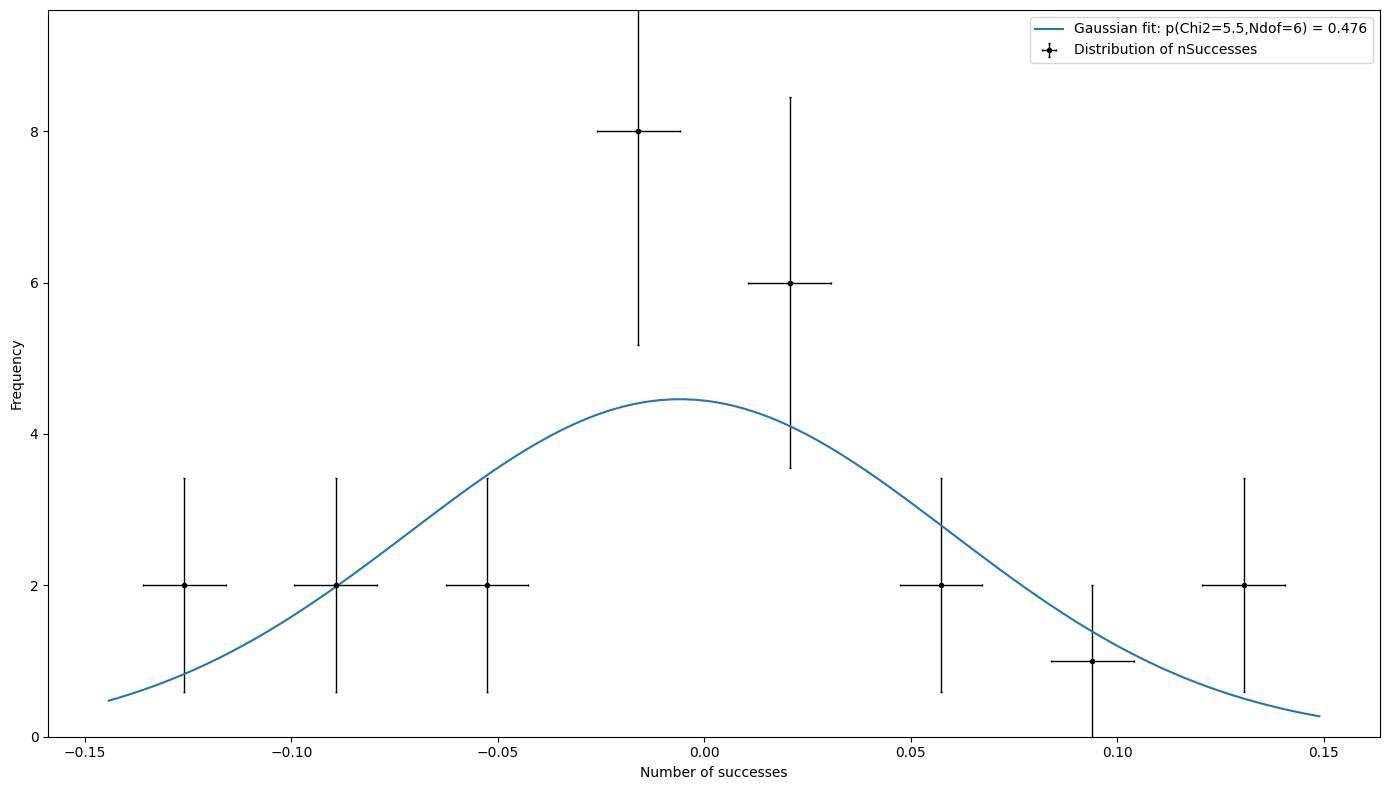

In [131]:


# axLin.scatter(x_data, periods_2, c='m')
# axLin.plot(x_data, linear_model(x_data, *minuitLin_1.values[:]), '-r')
# axLin.plot(x_data, linear_model(x_data, *minuitLin_2.values[:]), '-r')
xaxis = np.linspace(min(res1), max(res1), 100)
counts, bin_edges = np.histogram(res1,bins=8)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2
s_counts = np.sqrt(counts) 
x = bin_centers[counts>0]
y = counts[counts>0]
sy = s_counts[counts>0]

fig, ax = plt.subplots(figsize=(14, 8))
ax.errorbar(x, y, yerr=sy, xerr=0.01, label='Distribution of nSuccesses', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)
ax.set( ylim=(0, 1.2*np.max(y)), xlabel='Number of successes', ylabel='Frequency');


def func_gaussian(x, N, mu, sigma) :
    return N * stats.norm.pdf(x, mu, sigma)


chi2_gaussian = Chi2Regression(func_gaussian, x, y, sy)
chi2_gaussian.errordef = 1
minuit_gaussian = Minuit(chi2_gaussian, N=N_measurements, mu=0, sigma=0.03) #   
minuit_gaussian.migrad()       # Perform the actual fit
Chi2_gau = minuit_gaussian.fval
Ndof_gau = len(x) - 2          # 3 parameters in fit
Prob_gau = stats.chi2.sf(Chi2_gau, Ndof_gau)

yaxis = func_gaussian(xaxis, *minuit_gaussian.values[:])
ax.plot(xaxis, yaxis, '-', label=f'Gaussian fit: p(Chi2={Chi2_gau:.1f},Ndof={Ndof_gau:d}) = {Prob_gau:.3f}')
ax.legend()
fig.tight_layout()




### Ball on incline
 
- Rolling ball timing and gate positions: Remember, doing (too) many experiments won't decrease the error (why?)!
- Rolling ball acceleration: I.e. combining the above with gate times in quadratic fit.
- Rolling ball diameter and rail distance: Done with a caliper (DK: skydelaerer).
- Rolling ball incline angle: With goniometer (DK: vinkelmaaler) and from trigonometry.
- Rolling ball table angle: Measured by turning the experiment 180 degrees and cross checked by goniometer. Was it consistent with being level?
And finally, you should of course combine your measurements to one value of g for each setup and compare the value and precision with a reference.